Random Forest Classification Report (Clean Data):

              precision    recall  f1-score   support

           0       0.57      0.44      0.50        77
           1       0.55      0.67      0.61        79

    accuracy                           0.56       156
   macro avg       0.56      0.56      0.55       156
weighted avg       0.56      0.56      0.55       156



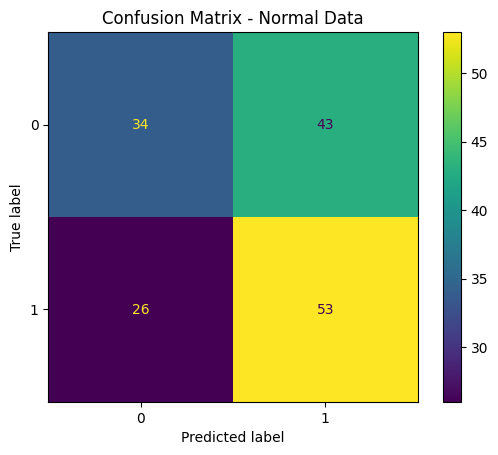

In [1]:
# Part 1: Data Loading, Preprocessing, and Fire Detection

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

# Load dataset
file_path = "forestfires.csv"  # Update this path if needed
data = pd.read_csv(file_path)

# Encode categorical features
data['month'] = LabelEncoder().fit_transform(data['month'])
data['day'] = LabelEncoder().fit_transform(data['day'])

# Create binary target variable: Fire detected or not
data['fire_detected'] = (data['area'] > 0).astype(int)

# Select features and target
X = data.drop(['area', 'fire_detected'], axis=1)
y = data['fire_detected']

# Standardize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and Evaluation
rf_pred = rf_model.predict(X_test)
print("Random Forest Classification Report (Clean Data):\n")
print(classification_report(y_test, rf_pred))

# Visualize Confusion Matrix
conf_matrix = confusion_matrix(y_test, rf_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title("Confusion Matrix - Normal Data")
plt.show()

# Save clean test predictions for comparison
np.save("clean_rf_predictions.npy", rf_pred)


Random Forest Classification Report (Clean Data):
              precision    recall  f1-score   support

           0       0.62      0.64      0.63        75
           1       0.66      0.64      0.65        81

    accuracy                           0.64       156
   macro avg       0.64      0.64      0.64       156
weighted avg       0.64      0.64      0.64       156



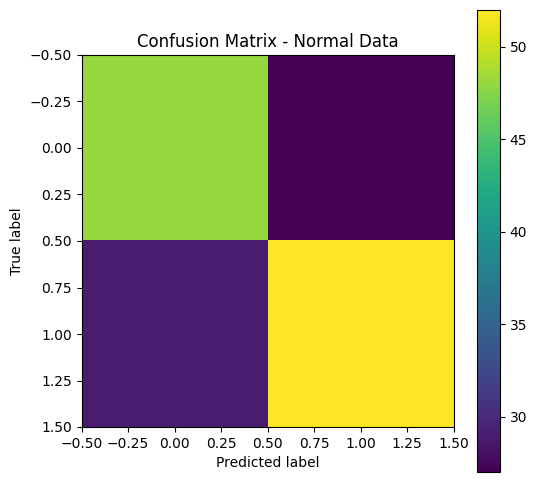

Random Forest Classification Report (Noisy Data):
              precision    recall  f1-score   support

           0       0.59      0.60      0.60        75
           1       0.62      0.62      0.62        81

    accuracy                           0.61       156
   macro avg       0.61      0.61      0.61       156
weighted avg       0.61      0.61      0.61       156



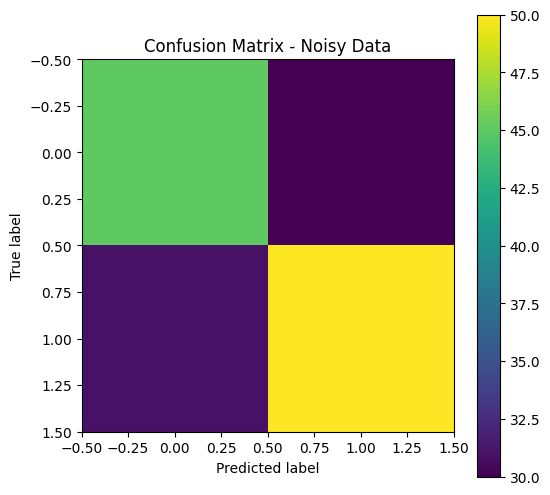

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

# Reload data (ensure data file exists and is preprocessed)
data_path = "forestfires.csv"
df = pd.read_csv(data_path)

# Encode categorical data and preprocess as in Part 1
df['month'] = df['month'].astype('category').cat.codes
df['day'] = df['day'].astype('category').cat.codes

# Features and target variable
X = df.drop(['area'], axis=1)
y = (df['area'] > 0).astype(int)  # Binary classification: 0 = no fire, 1 = fire

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Save the split data for consistency
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

# Standardize numerical data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and performance metrics
y_pred_clean = rf_model.predict(X_test)
print("Random Forest Classification Report (Clean Data):")
print(classification_report(y_test, y_pred_clean))

# Confusion matrix for clean data
conf_matrix_clean = confusion_matrix(y_test, y_pred_clean)
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix - Normal Data")
plt.imshow(conf_matrix_clean, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Add noise to data
X_test_noisy = X_test + np.random.normal(0, 0.1, X_test.shape)  # Adding Gaussian noise

# Predict on noisy data
y_pred_noisy = rf_model.predict(X_test_noisy)
print("Random Forest Classification Report (Noisy Data):")
print(classification_report(y_test, y_pred_noisy))

# Confusion matrix for noisy data
conf_matrix_noisy = confusion_matrix(y_test, y_pred_noisy)
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix - Noisy Data")
plt.imshow(conf_matrix_noisy, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [4]:
import pandas as pd
import numpy as np
from cryptography.fernet import Fernet
import hmac
import hashlib

# Load the dataset
data = pd.read_csv("forestfires.csv")

# Generate encryption key and initialize cipher
encryption_key = Fernet.generate_key()
cipher = Fernet(encryption_key)

# Function to encrypt data
def encrypt_data(data):
    encrypted = data.applymap(lambda x: cipher.encrypt(str(x).encode()).decode())
    return encrypted

# Function to decrypt data
def decrypt_data(data):
    decrypted = data.applymap(lambda x: cipher.decrypt(x.encode()).decode())
    return decrypted

# Add HMAC for data integrity
def generate_hmac(row, secret_key):
    message = row.to_string().encode()
    return hmac.new(secret_key.encode(), message, hashlib.sha256).hexdigest()

# Encrypt the dataset
encrypted_data = encrypt_data(data)

# Generate HMAC for each row
secret_key = "my_secret_key"
encrypted_data["hmac"] = encrypted_data.apply(lambda row: generate_hmac(row, secret_key), axis=1)

# Decrypt and validate data integrity
def validate_data(row, secret_key):
    hmac_value = row["hmac"]
    row_without_hmac = row.drop("hmac")
    expected_hmac = generate_hmac(row_without_hmac, secret_key)
    return hmac_value == expected_hmac

decrypted_data = decrypt_data(encrypted_data.drop("hmac", axis=1))
encrypted_data["is_valid"] = encrypted_data.apply(lambda row: validate_data(row, secret_key), axis=1)

# Print the first few rows to confirm encryption, decryption, and integrity
print("Encrypted Data Sample:")
print(encrypted_data.head())
print("Decrypted Data Sample:")
print(decrypted_data.head())


C:\Windows\Temp\ipykernel_7352\355035874.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  encrypted = data.applymap(lambda x: cipher.encrypt(str(x).encode()).decode())
C:\Windows\Temp\ipykernel_7352\355035874.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  decrypted = data.applymap(lambda x: cipher.decrypt(x.encode()).decode())


Encrypted Data Sample:
                                                   X  \
0  gAAAAABnVM2byK9QS2-NNrkJ5w_DzTYq_cT-jWevzxhziL...   
1  gAAAAABnVM2b-hlban8-2vfdCK2Revc6K3SEN2OVNknMco...   
2  gAAAAABnVM2bQhqdYMu4v0tSe0MMXF7Eik8d2tAuC9u_bt...   
3  gAAAAABnVM2bYA9X4P_i_LshIRY2ztsAgd7YDkVqFw-_W2...   
4  gAAAAABnVM2bDYBjo1qE3ykGdt2fQ61p3SgU7KIUHfP6lf...   

                                                   Y  \
0  gAAAAABnVM2bnhC-njjBf4moDpGZhv3tlwHuF8hb8f-o5D...   
1  gAAAAABnVM2bdOEWSkkA1ivtuAtCz33gcLd51ZPqDxdso9...   
2  gAAAAABnVM2bh81G-aJ-2-4DfT8TDmf7iGB7FAdr-6rsIf...   
3  gAAAAABnVM2b_VGcrKaeDP8xAwj9m7eLFDhykZswi2Grhn...   
4  gAAAAABnVM2b9duiwjZSBoZs0dH7nKNQM9sxmxWoQbJ63x...   

                                               month  \
0  gAAAAABnVM2bbqTLX4EQtnVQg-jfDmGkuKZgV_vR8NHNnI...   
1  gAAAAABnVM2bpyxQlTVST8-8K4fDtBbkqA9FNnC6hUJFvG...   
2  gAAAAABnVM2bjh4ZK7YP0go8AbtbN1PeLFPGVbir3GW4qE...   
3  gAAAAABnVM2b3qDNMRnTwHTFGnf-IEULI3sxHWerEiYytW...   
4  gAAAAABnVM2byoYg8O9i

In [5]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Simulate tampered data by introducing random noise
def add_noise(data, noise_factor=0.1):
    noisy_data = data.copy()
    noisy_data.iloc[:, :-1] += noise_factor * np.random.randn(*data.iloc[:, :-1].shape)
    return noisy_data

# Preprocess the dataset (before introducing noise)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop(columns=["hmac"], errors="ignore"))

# Add noise to simulate tampered data
tampered_data = add_noise(pd.DataFrame(data_scaled), noise_factor=0.5)

# Train Isolation Forest on clean data
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(data_scaled)

# Predict anomalies
clean_anomalies = iso_forest.predict(data_scaled)  # 1 = normal, -1 = anomaly
tampered_anomalies = iso_forest.predict(tampered_data)  # 1 = normal, -1 = anomaly

# Visualize anomaly detection results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(data_scaled[:, 0], data_scaled[:, 1], c=clean_anomalies, cmap="coolwarm", label="Clean Data")
axes[0].set_title("Anomaly Detection on Clean Data")
axes[0].legend()

axes[1].scatter(tampered_data.iloc[:, 0], tampered_data.iloc[:, 1], c=tampered_anomalies, cmap="coolwarm", label="Tampered Data")
axes[1].set_title("Anomaly Detection on Tampered Data")
axes[1].legend()

plt.show()


ValueError: could not convert string to float: 'mar'

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from cryptography.fernet import Fernet
import random
import string
import hashlib
import hmac

# Function to add noise
def add_noise(data, noise_factor=0.1):
    noisy_data = data.copy()
    for column in noisy_data.select_dtypes(include=[np.number]).columns:
        noise = np.random.normal(0, noise_factor, noisy_data[column].shape)
        noisy_data[column] += noise
    return noisy_data

# Load the dataset
data = pd.read_csv('forestfires.csv')

# Encode categorical variables (month, day)
categorical_columns = ['month', 'day']
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Preprocess the dataset (before introducing noise)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop(columns=["hmac"], errors="ignore"))

# Add noise to simulate tampered data
tampered_data = add_noise(pd.DataFrame(data_scaled), noise_factor=0.5)

# Simulate encryption and decryption for data security
key = Fernet.generate_key()
cipher = Fernet(key)

def encrypt_value(value):
    return cipher.encrypt(str(value).encode())

def decrypt_value(value):
    return cipher.decrypt(value).decode()

# Encrypt the dataset
encrypted_data = data.applymap(lambda x: encrypt_value(x) if isinstance(x, (int, float, str)) else x)

# Compute HMAC for data integrity
def compute_hmac(row, key):
    row_str = "".join(map(str, row.values))
    return hmac.new(key, row_str.encode(), hashlib.sha256).hexdigest()

data["hmac"] = data.apply(lambda row: compute_hmac(row, key), axis=1)

# Decrypt and validate data
decrypted_data = encrypted_data.applymap(lambda x: decrypt_value(x) if isinstance(x, bytes) else x)
decrypted_data = pd.DataFrame(decrypted_data, columns=data.columns)  # Match column names
decrypted_data["is_valid"] = decrypted_data.apply(
    lambda row: compute_hmac(row.drop("hmac"), key) == row["hmac"], axis=1
)

# Print results
print("Encrypted Data Sample:")
print(encrypted_data.head())
print("\nDecrypted Data Sample:")
print(decrypted_data.head())


C:\Windows\Temp\ipykernel_7352\3158629655.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  encrypted_data = data.applymap(lambda x: encrypt_value(x) if isinstance(x, (int, float, str)) else x)
C:\Windows\Temp\ipykernel_7352\3158629655.py:57: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  decrypted_data = encrypted_data.applymap(lambda x: decrypt_value(x) if isinstance(x, bytes) else x)


Encrypted Data Sample:
                                                   X  \
0  b'gAAAAABnVM4IQ8BK-22uo_U9e5S4iFgGLLE_mCbaO7wf...   
1  b'gAAAAABnVM4IVXKmSIxjffqZni9PBVrTze_94PhbrxB3...   
2  b'gAAAAABnVM4IqLJRCMdQqZbMxBZy1NfflUO8IKpO6wqw...   
3  b'gAAAAABnVM4I6xE3iZiisZz01zTDTKsUuTjmjpaRhTtK...   
4  b'gAAAAABnVM4IvPA62sOzfBdGOMHC8rtfaBvF6dnZ-i3j...   

                                                   Y  \
0  b'gAAAAABnVM4I_MmIF5H1kIZCHf-st-G0gWnbIJ2mVeYa...   
1  b'gAAAAABnVM4IHYBm0uUkqkQ7ycfkJ9GXcxyu_d-9jEiO...   
2  b'gAAAAABnVM4Iebev5OUrppC7jJeErBmiXk8fFYB9F0s9...   
3  b'gAAAAABnVM4I6aSHihn1Mj7o0PQPokZzA0RgBSEdHuyP...   
4  b'gAAAAABnVM4IAVy4g7tVEoNWK87twW3NY7jYBiXviI1-...   

                                               month  \
0  b'gAAAAABnVM4I1aJWRGSr_9NccJLRWHBuZ-ETVm_-eZni...   
1  b'gAAAAABnVM4IDVcrdCohHIEk-YfbWLz_EXyBB2Cf2t2n...   
2  b'gAAAAABnVM4IiY1tFu9nFy2K9KFGsjhoh-6coxKTi0iX...   
3  b'gAAAAABnVM4I1JZHdj3aMdiqvD1Xz8Y3lS35Lq76qAjd...   
4  b'gAAAAABnVM4Iho9Bks

C:\Windows\Temp\ipykernel_7352\1803759696.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  encrypted_data = data.drop(columns=["hmac"]).applymap(lambda x: cipher_suite.encrypt(str(x).encode()) if pd.notnull(x) else x)
C:\Windows\Temp\ipykernel_7352\1803759696.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  decrypted_data = encrypted_data.drop(columns=["hmac"]).applymap(lambda x: cipher_suite.decrypt(x).decode() if pd.notnull(x) else x)
C:\Windows\Temp\ipykernel_7352\1803759696.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=integrity_counts.index, y=integrity_counts.values, palette="coolwarm")


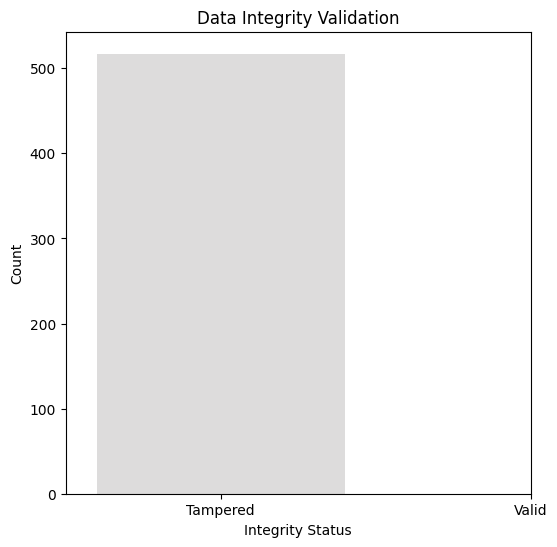

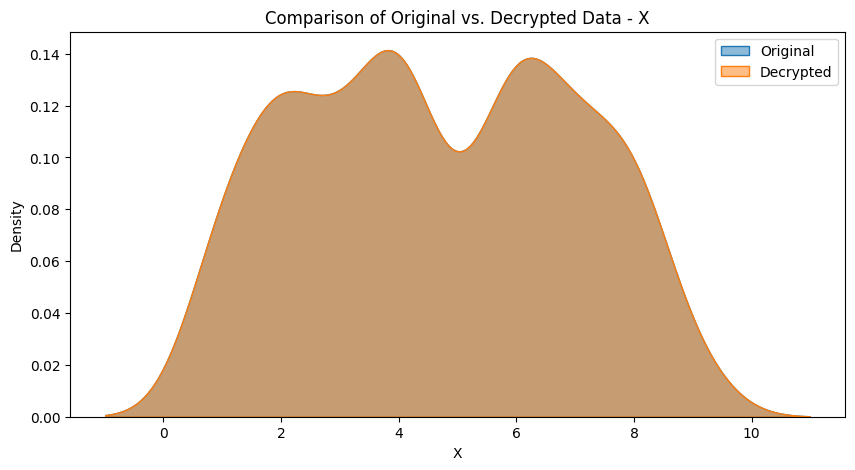

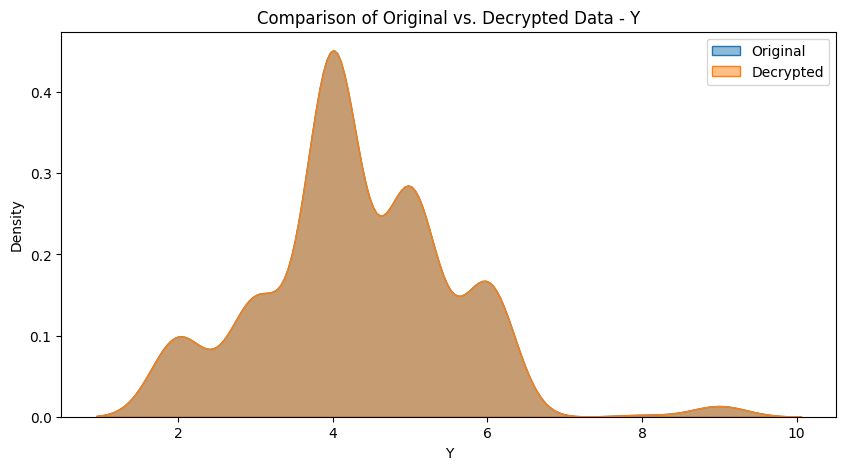

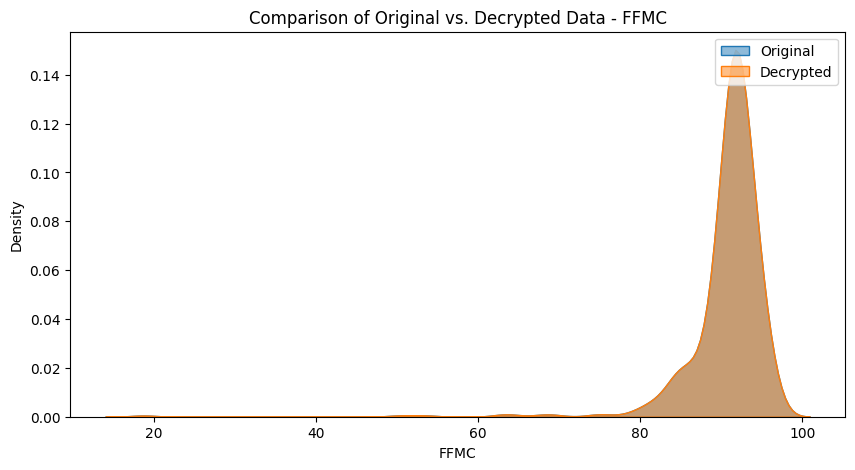

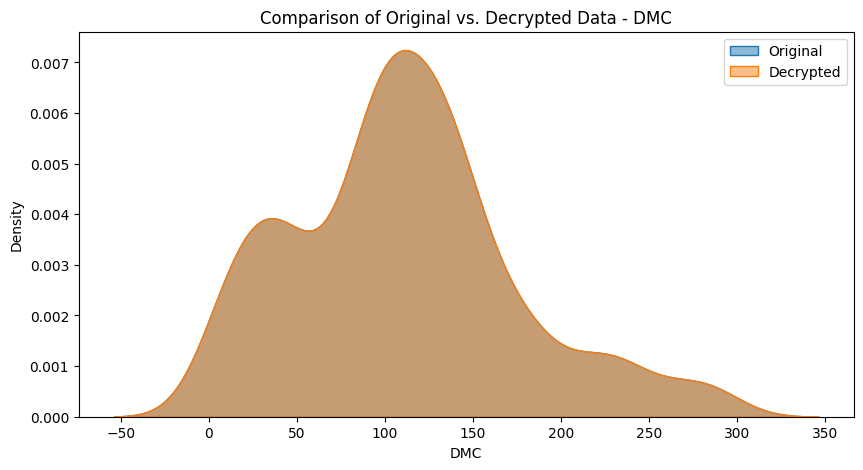

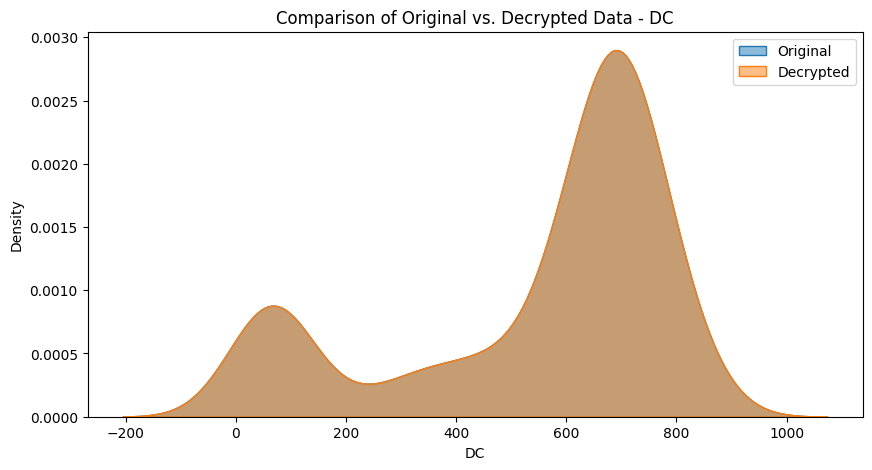

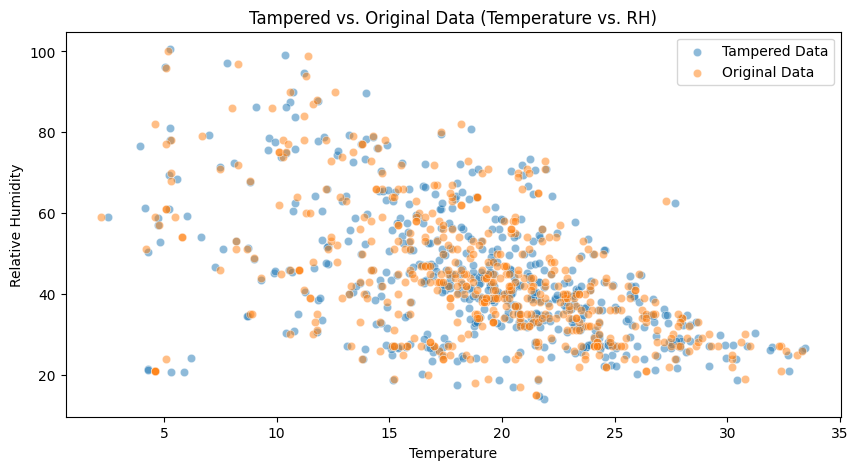

Encrypted Data Sample:
                                                   X  \
0  b'gAAAAABnVM6V8xV-85UEpgko-jt9Vcmpgk49mRLvmsgh...   
1  b'gAAAAABnVM6VzBA9RPe39lB1_c3gyz0aOdCrjTZXAO61...   
2  b'gAAAAABnVM6VFkLY5wyPXghf1U1HEF3IkQzBNn8tSIHr...   
3  b'gAAAAABnVM6VESSQsDYwMbQOLOmfVWHSqeEJHQul8Hr9...   
4  b'gAAAAABnVM6V78rpj-k7OdKqzhUMF3H_iwaI59HNQL31...   

                                                   Y  \
0  b'gAAAAABnVM6VPSIWJrjvUk1PepN3pFkcRWtESZfhBw-G...   
1  b'gAAAAABnVM6V7pOlrCJZHKcOOBF5R5G-2NC5Ug3g3_RP...   
2  b'gAAAAABnVM6VphG9un59_vEkeKiQ72GRV8h8YLmXecga...   
3  b'gAAAAABnVM6V7GyU3H4MZ7_tLXjZTQVQ1eNCFLheqNuR...   
4  b'gAAAAABnVM6VONgL-WXiQ1VU7GEHkylA2e6tDxOMXN86...   

                                               month  \
0  b'gAAAAABnVM6VvAgc-eZ_nXAq0yzuW--Be6PF_LOAum93...   
1  b'gAAAAABnVM6V9CUtqKrQKezaG_Tdt3zDWhhsz7UhqQHY...   
2  b'gAAAAABnVM6VrsJGSJd85YVwKnbOZeKmaxWz3JjMw0OB...   
3  b'gAAAAABnVM6VeFcIWUerPs8LpbT21ma6sJlO9ZCOVzk6...   
4  b'gAAAAABnVM6VlKlx-q

In [7]:
import pandas as pd
import numpy as np
from cryptography.fernet import Fernet
import hashlib
import hmac
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Generate a symmetric encryption key
key = Fernet.generate_key()
cipher_suite = Fernet(key)

# Function to encrypt data
def encrypt_data(data, cipher_suite):
    return data.applymap(lambda x: cipher_suite.encrypt(str(x).encode()) if pd.notnull(x) else x)

# Function to decrypt data
def decrypt_data(data, cipher_suite):
    return data.applymap(lambda x: cipher_suite.decrypt(x).decode() if pd.notnull(x) else x)

# Function to compute HMAC for each row
def compute_hmac(row, key):
    row_str = "".join(map(str, row.values))
    return hmac.new(key, row_str.encode(), hashlib.sha256).hexdigest()

# Load dataset
data_path = 'forestfires.csv'
data = pd.read_csv(data_path)

# Generate HMAC key for integrity checks
hmac_key = b'super_secret_hmac_key'

# Add HMAC for each row
data["hmac"] = data.apply(lambda row: compute_hmac(row, hmac_key), axis=1)

# Encrypt dataset
encrypted_data = data.drop(columns=["hmac"]).applymap(lambda x: cipher_suite.encrypt(str(x).encode()) if pd.notnull(x) else x)
encrypted_data["hmac"] = data["hmac"]

# Decrypt dataset
decrypted_data = encrypted_data.drop(columns=["hmac"]).applymap(lambda x: cipher_suite.decrypt(x).decode() if pd.notnull(x) else x)
decrypted_data["hmac"] = encrypted_data["hmac"]

# Validate HMAC during decryption
decrypted_data["is_valid"] = decrypted_data.apply(
    lambda row: compute_hmac(row.drop(["hmac", "is_valid"], errors="ignore"), hmac_key) == row["hmac"], axis=1
)

# Convert decrypted data back to numeric types
numeric_columns = ["X", "Y", "FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain", "area"]
decrypted_data[numeric_columns] = decrypted_data[numeric_columns].apply(pd.to_numeric)

# Visualization: Check data integrity
integrity_counts = decrypted_data["is_valid"].value_counts()
plt.figure(figsize=(6, 6))
sns.barplot(x=integrity_counts.index, y=integrity_counts.values, palette="coolwarm")
plt.title("Data Integrity Validation")
plt.xlabel("Integrity Status")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Tampered", "Valid"])
plt.show()

# Visualization: Compare original and decrypted data
for col in numeric_columns[:5]:  # Limit to 5 features for simplicity
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data[col], label="Original", fill=True, alpha=0.5)
    sns.kdeplot(decrypted_data[col], label="Decrypted", fill=True, alpha=0.5)
    plt.title(f"Comparison of Original vs. Decrypted Data - {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Visualization: Noise effect on tampered data
def add_noise(data, noise_factor=0.5):
    noisy_data = data.copy()
    for col in numeric_columns:
        noisy_data[col] += noise_factor * np.random.normal(size=noisy_data[col].shape)
    return noisy_data

tampered_data = add_noise(decrypted_data[numeric_columns])
plt.figure(figsize=(10, 5))
sns.scatterplot(x=tampered_data["temp"], y=tampered_data["RH"], label="Tampered Data", alpha=0.5)
sns.scatterplot(x=decrypted_data["temp"], y=decrypted_data["RH"], label="Original Data", alpha=0.5)
plt.title("Tampered vs. Original Data (Temperature vs. RH)")
plt.xlabel("Temperature")
plt.ylabel("Relative Humidity")
plt.legend()
plt.show()

# Summary: Display encrypted and decrypted data samples
print("Encrypted Data Sample:")
print(encrypted_data.head())

print("\nDecrypted Data Sample:")
print(decrypted_data.head())


In [8]:
import pandas as pd
import numpy as np
from cryptography.fernet import Fernet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
data_path = "forestfires.csv"
data = pd.read_csv(data_path)

# Encode categorical variables
label_encoders = {}
for col in ["month", "day"]:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Generate encryption key
key = Fernet.generate_key()
cipher = Fernet(key)

# Encrypt data
def encrypt_column(column):
    return column.apply(lambda x: cipher.encrypt(str(x).encode()))

encrypted_data = data.copy()
for col in data.columns:
    encrypted_data[col] = encrypt_column(data[col])

# Save encrypted data for secure transmission simulation
encrypted_data.to_csv("encrypted_forestfires.csv", index=False)

# Decrypt data
def decrypt_column(column):
    return column.apply(lambda x: float(cipher.decrypt(x.encode())))

decrypted_data = encrypted_data.copy()
for col in data.columns:
    decrypted_data[col] = decrypt_column(encrypted_data[col])

# Preprocess decrypted data
X = decrypted_data.drop(columns=["area"])
y = decrypted_data["area"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add noise to simulate tampered data
def add_noise(data, noise_factor=0.1):
    noisy_data = data.copy()
    noise = noise_factor * np.random.normal(size=data.shape)
    noisy_data += noise
    return noisy_data

tampered_data = add_noise(X_scaled)

# Save prepared data for model training
np.savez("secure_data.npz", X=X_scaled, y=y, tampered=tampered_data)


AttributeError: 'bytes' object has no attribute 'encode'

In [9]:
import pandas as pd
import numpy as np
from cryptography.fernet import Fernet
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load dataset
data_path = "forestfires.csv"
data = pd.read_csv(data_path)

# Encode categorical variables
label_encoders = {}
for col in ["month", "day"]:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Generate encryption key
key = Fernet.generate_key()
cipher = Fernet(key)

# Encrypt data
def encrypt_column(column):
    return column.apply(lambda x: cipher.encrypt(str(x).encode()))

encrypted_data = data.copy()
for col in data.columns:
    encrypted_data[col] = encrypt_column(data[col])

# Save encrypted data for secure transmission simulation
encrypted_data.to_csv("encrypted_forestfires.csv", index=False)

# Decrypt data
def decrypt_column(column):
    return column.apply(lambda x: float(cipher.decrypt(x).decode()))

decrypted_data = encrypted_data.copy()
for col in data.columns:
    decrypted_data[col] = decrypt_column(encrypted_data[col])

# Preprocess decrypted data
X = decrypted_data.drop(columns=["area"])
y = decrypted_data["area"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add noise to simulate tampered data
def add_noise(data, noise_factor=0.1):
    noisy_data = data.copy()
    noise = noise_factor * np.random.normal(size=data.shape)
    noisy_data += noise
    return noisy_data

tampered_data = add_noise(X_scaled)

# Save prepared data for model training
np.savez("secure_data.npz", X=X_scaled, y=y, tampered=tampered_data)


In [11]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load secure data
data = np.load("secure_data.npz")
X = data["X"]
y = data["y"]  # Assuming the target variable remains continuous for regression
tampered_data = data["tampered"]

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest for Regression
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# Evaluate model on original data
print("Original Data:")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

# Test model on tampered data
tampered_pred = rf_regressor.predict(tampered_data)
print("\nTampered Data:")
print(f"Mean Squared Error: {mean_squared_error(y_test, tampered_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, tampered_pred):.2f}")

# Visualize Predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, label="Original Data Predictions", alpha=0.6)
plt.scatter(y_test, tampered_pred, label="Tampered Data Predictions", alpha=0.6, color="red")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="black")
plt.title("Prediction Comparison: Original vs. Tampered Data")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

# Save model for deployment
import joblib
joblib.dump(rf_regressor, "rf_regressor_secure.pkl")


Original Data:
Mean Squared Error: 8801.08
R2 Score: -0.11

Tampered Data:


ValueError: Found input variables with inconsistent numbers of samples: [156, 517]

Original Data:
Mean Squared Error: 8801.08
R2 Score: -0.11

Tampered Data:
Mean Squared Error: 9347.28
R2 Score: -0.17


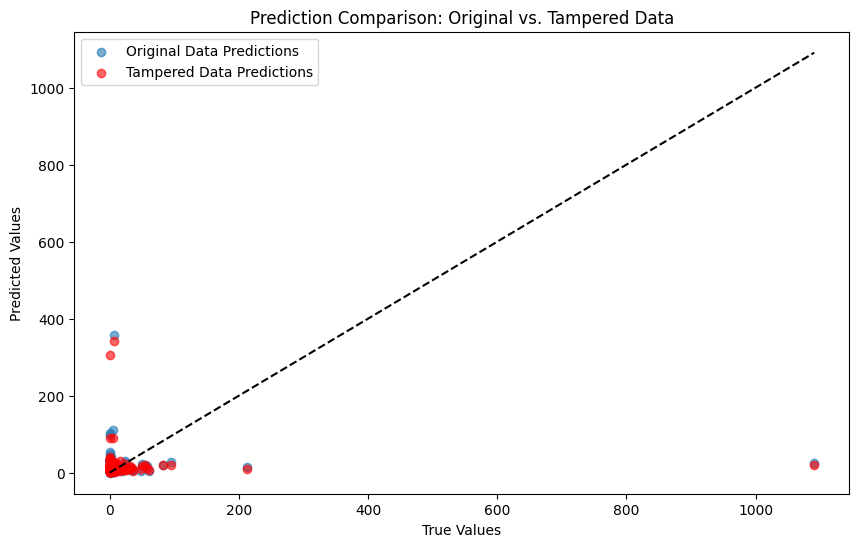

['rf_regressor_secure.pkl']

In [12]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load secure data
data = np.load("secure_data.npz")
X = data["X"]
y = data["y"]  # Assuming the target variable remains continuous for regression

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Generate tampered data for X_test
def add_noise(data, noise_factor=0.2):
    noisy_data = data + noise_factor * np.random.normal(size=data.shape)
    return noisy_data

tampered_X_test = add_noise(X_test)

# Train Random Forest for Regression
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Evaluate model on original test data
y_pred = rf_regressor.predict(X_test)
print("Original Data:")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

# Evaluate model on tampered test data
tampered_pred = rf_regressor.predict(tampered_X_test)
print("\nTampered Data:")
print(f"Mean Squared Error: {mean_squared_error(y_test, tampered_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, tampered_pred):.2f}")

# Visualize Predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, label="Original Data Predictions", alpha=0.6)
plt.scatter(y_test, tampered_pred, label="Tampered Data Predictions", alpha=0.6, color="red")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="black")
plt.title("Prediction Comparison: Original vs. Tampered Data")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

# Save model for deployment
import joblib
joblib.dump(rf_regressor, "rf_regressor_secure.pkl")


In [13]:
import pandas as pd
from cryptography.fernet import Fernet
import hashlib
import hmac

# Generate encryption key
encryption_key = Fernet.generate_key()
cipher = Fernet(encryption_key)

# Function to encrypt a single column
def encrypt_column(column):
    return column.apply(lambda x: cipher.encrypt(str(x).encode()))

# Function to decrypt a single column
def decrypt_column(column):
    return column.apply(lambda x: cipher.decrypt(x).decode())

# Function to compute HMAC for a given row
def compute_hmac(row, secret_key):
    hmac_obj = hmac.new(secret_key.encode(), msg=str(row.to_json()).encode(), digestmod=hashlib.sha256)
    return hmac_obj.hexdigest()

# Load dataset
data = pd.read_csv("forestfires.csv")

# Define secret key for HMAC
hmac_key = "secure_hmac_key"

# Encrypt the data
encrypted_data = data.copy()
for col in data.columns:
    encrypted_data[col] = encrypt_column(data[col])

# Add HMAC for each row to ensure integrity
encrypted_data["hmac"] = encrypted_data.apply(lambda row: compute_hmac(row, hmac_key), axis=1)

print("Encrypted Data Sample:")
print(encrypted_data.head())

# Validate HMAC and decrypt the data
def validate_hmac(row, secret_key):
    hmac_computed = compute_hmac(row[:-1], secret_key)  # Exclude HMAC column
    return hmac_computed == row["hmac"]

decrypted_data = encrypted_data.copy()
decrypted_data["is_valid"] = encrypted_data.apply(lambda row: validate_hmac(row, hmac_key), axis=1)

# Decrypt valid rows
for col in data.columns:
    decrypted_data[col] = decrypt_column(encrypted_data[col])

print("\nDecrypted Data Sample:")
print(decrypted_data.head())

# Save encrypted and decrypted data for further stages
encrypted_data.to_csv("encrypted_forestfires.csv", index=False)
decrypted_data.to_csv("decrypted_forestfires.csv", index=False)


Encrypted Data Sample:
                                                   X  \
0  b'gAAAAABnVPbakARenXeXa3t5tcVuuFNkrzU0wYlVAzZJ...   
1  b'gAAAAABnVPba2PoEkCwLLey2SPEYdXQYkutnM568a5_Y...   
2  b'gAAAAABnVPbaf89wl0-3Hw0-9Cv8PTyc6t3V_Pq0KasM...   
3  b'gAAAAABnVPbaOK8DzdWrfVVu-S8jTfTdLQNWsgjlTAN3...   
4  b'gAAAAABnVPbaE93yswpJstPQg3r3D_tGeBBJvzR8m9Sk...   

                                                   Y  \
0  b'gAAAAABnVPba_jpYW79D1xkj7QxunMHcru_OeThLjyvE...   
1  b'gAAAAABnVPban4JIczpgAItmZ41B1lqoA5zEh9ufdF3D...   
2  b'gAAAAABnVPbal9rHV29Y8SB373XEJIkMmZ6O2bmZYN7_...   
3  b'gAAAAABnVPbaqSg_pwhl4h22NvY4OMQVxDYZx1thPtJz...   
4  b'gAAAAABnVPbaxoie1kVqpjS2oSv2u2z2nvHGGCM3k1u8...   

                                               month  \
0  b'gAAAAABnVPbalWbtk1O_vjkMXpS7fn9jvro2WZm5E-cf...   
1  b'gAAAAABnVPbaX4fyPkiIjxEHCO360883QiPhEG-Qj6U-...   
2  b'gAAAAABnVPbaBqahdomFMIGibfO98tqfdcc0LkU9eOFE...   
3  b'gAAAAABnVPbaS0iEjm7XOQtjS2nK2WhwvGl3JlTu6iQJ...   
4  b'gAAAAABnVPbadVyGTy

Model Evaluation on Clean, Secure Data:
Mean Squared Error: 8167.87
R2 Score: -0.03


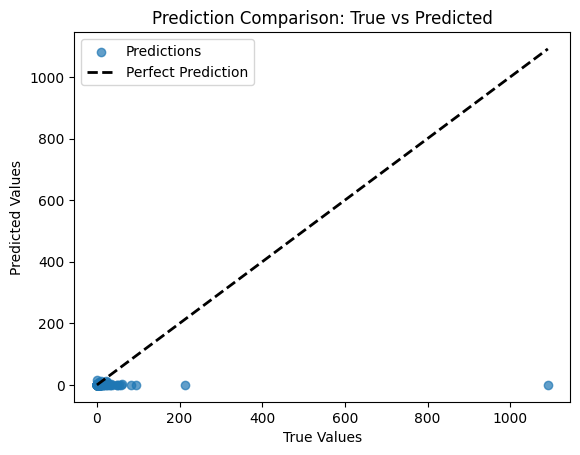


Model saved as rf_regressor_secure.pkl


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pickle

# Load decrypted data
decrypted_data = pd.read_csv("decrypted_forestfires.csv")

# Preprocess data
# Drop non-numeric columns and separate target variable ('area')
X = decrypted_data.drop(columns=["area"], errors="ignore")  # Features
y = decrypted_data["area"]  # Target variable

# Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Model on clean, secure data
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Evaluate model on the test set
y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation on Clean, Secure Data:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

# Visualize predictions vs true values
plt.scatter(y_test, y_pred, alpha=0.7, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Perfect Prediction")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Prediction Comparison: True vs Predicted")
plt.legend()
plt.show()

# Save the model for future use
model_filename = "rf_regressor_secure.pkl"
with open(model_filename, "wb") as model_file:
    pickle.dump(rf_regressor, model_file)

print(f"\nModel saved as {model_filename}")


Number of anomalies in training data: 18
Number of anomalies in testing data: 0


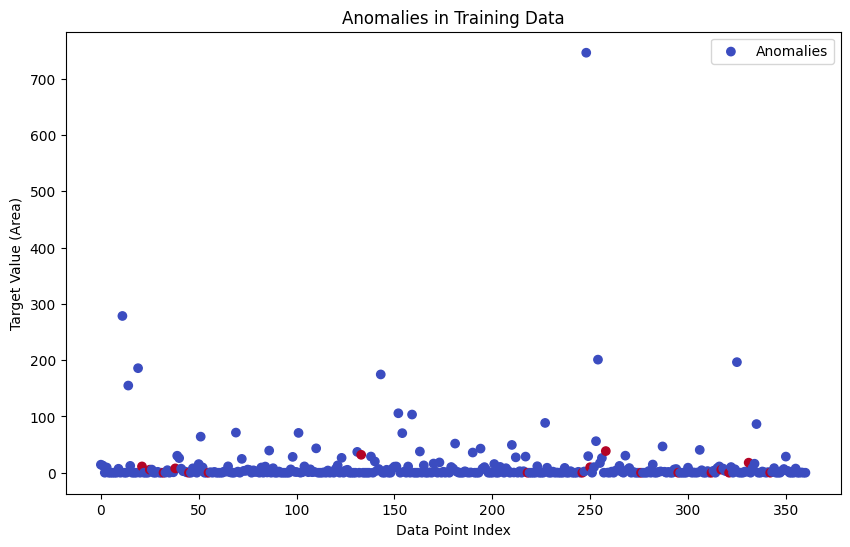

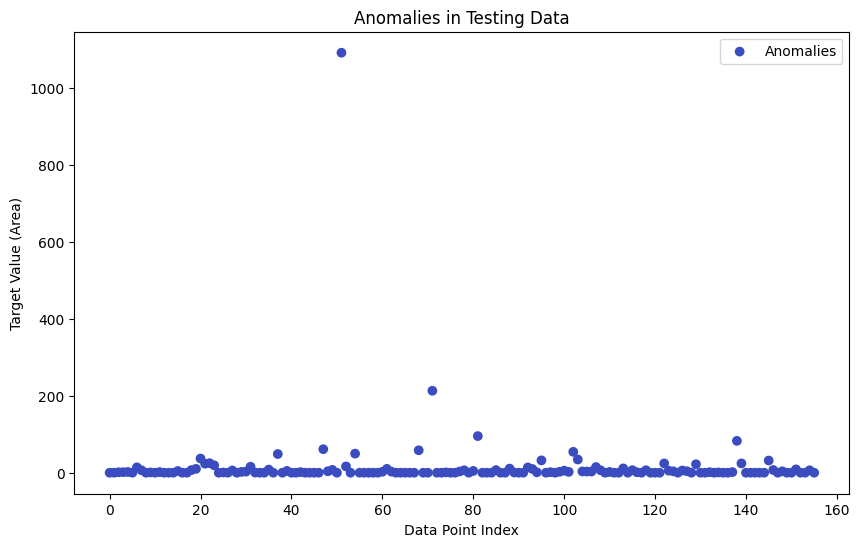

Anomaly detection results saved to 'anomaly_detection_results.csv'.


In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load decrypted data
decrypted_data = pd.read_csv("decrypted_forestfires.csv")

# Preprocess the data
# Drop non-numeric columns and separate target variable ('area')
X = decrypted_data.drop(columns=["area"], errors="ignore")  # Features
y = decrypted_data["area"]  # Target variable

# Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X)

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Anomaly Detection using Isolation Forest
anomaly_detector = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
anomaly_detector.fit(X_train)

# Detect anomalies on the training data
train_anomalies = anomaly_detector.predict(X_train)
test_anomalies = anomaly_detector.predict(X_test)

# Convert predictions (-1 = anomaly, 1 = normal) to boolean
train_anomalies = train_anomalies == -1
test_anomalies = test_anomalies == -1

# Count anomalies in the training and test datasets
num_train_anomalies = np.sum(train_anomalies)
num_test_anomalies = np.sum(test_anomalies)

print(f"Number of anomalies in training data: {num_train_anomalies}")
print(f"Number of anomalies in testing data: {num_test_anomalies}")

# Visualize anomalies in training and testing data
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_train)), y_train, c=train_anomalies, cmap="coolwarm", label="Anomalies")
plt.title("Anomalies in Training Data")
plt.xlabel("Data Point Index")
plt.ylabel("Target Value (Area)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, c=test_anomalies, cmap="coolwarm", label="Anomalies")
plt.title("Anomalies in Testing Data")
plt.xlabel("Data Point Index")
plt.ylabel("Target Value (Area)")
plt.legend()
plt.show()

# Save results for reporting
anomaly_results = pd.DataFrame({
    "Feature Data": list(X_test),
    "True Target": y_test.values,
    "Is Anomaly": test_anomalies
})
anomaly_results.to_csv("anomaly_detection_results.csv", index=False)
print("Anomaly detection results saved to 'anomaly_detection_results.csv'.")


Random Forest Results:
  Clean Data - MSE: 8167.94, R2: -0.03
  Noisy Data - MSE: 8162.35, R2: -0.03

Linear Regression Results:
  Clean Data - MSE: 7919.89, R2: 0.00
  Noisy Data - MSE: 7866.51, R2: 0.01

Decision Tree Results:
  Clean Data - MSE: 8173.55, R2: -0.03
  Noisy Data - MSE: 8170.09, R2: -0.03



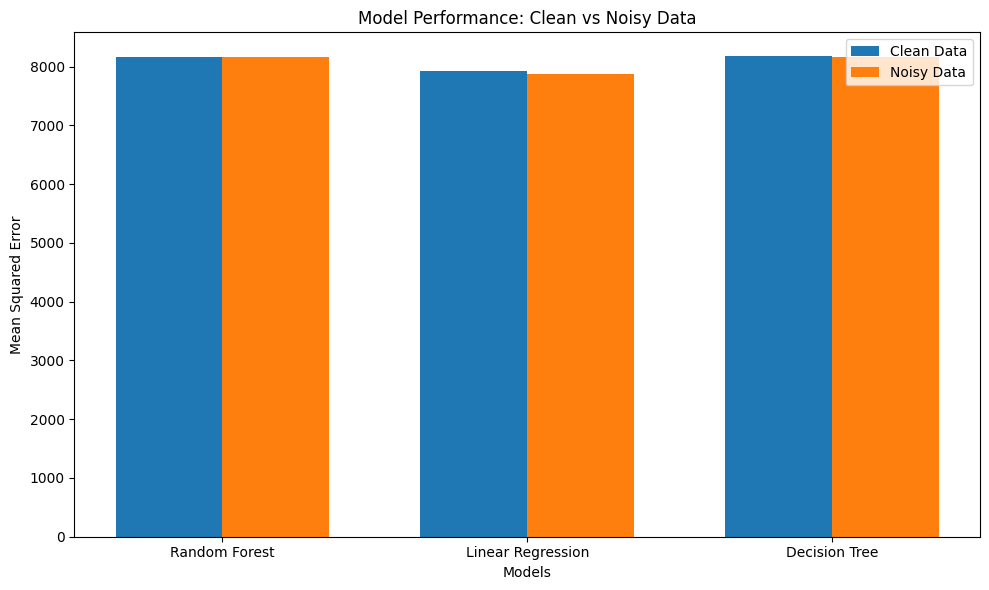

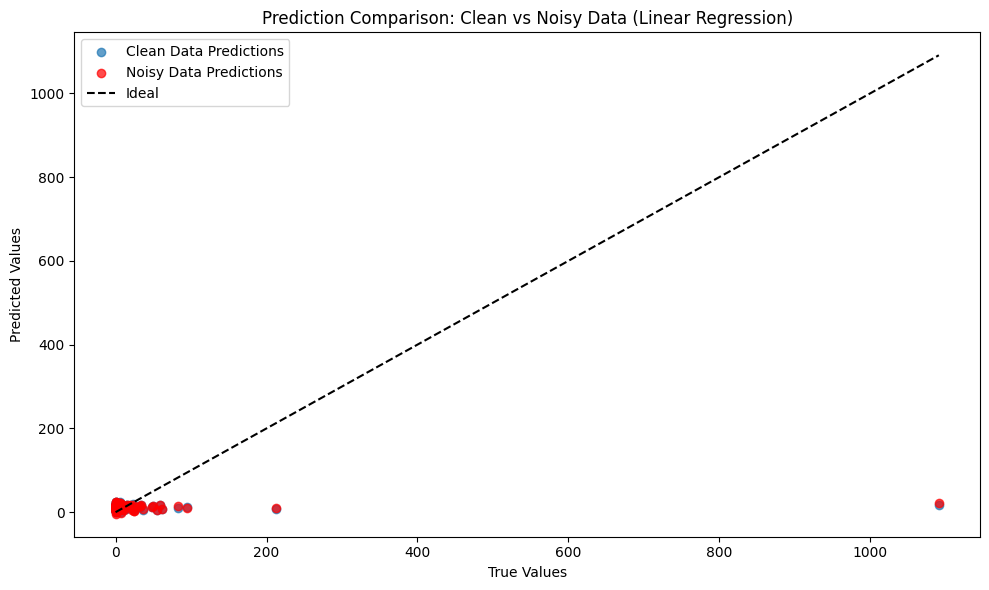

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Function to add noise to the dataset
def add_noise(data, noise_factor=0.2):
    noisy_data = data.copy()
    for col in noisy_data.columns:
        if noisy_data[col].dtype in ['float64', 'int64']:
            noisy_data[col] += noise_factor * noisy_data[col].std() * np.random.randn(len(noisy_data))
    return noisy_data

# Load decrypted data
data = pd.read_csv("decrypted_forestfires.csv")

# Preprocess the data
X = data.drop(columns=["area"], errors="ignore")  # Features
y = data["area"]  # Target variable

# Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X)

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Create a noisy version of the test data
X_test_noisy = add_noise(pd.DataFrame(X_test), noise_factor=0.5)

# Initialize models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

# Dictionary to store results
results = {}

# Train and test models on clean and noisy data
for name, model in models.items():
    # Train on clean data
    model.fit(X_train, y_train)
    
    # Predictions on clean data
    y_pred_clean = model.predict(X_test)
    mse_clean = mean_squared_error(y_test, y_pred_clean)
    r2_clean = r2_score(y_test, y_pred_clean)
    
    # Predictions on noisy data
    y_pred_noisy = model.predict(X_test_noisy)
    mse_noisy = mean_squared_error(y_test, y_pred_noisy)
    r2_noisy = r2_score(y_test, y_pred_noisy)
    
    # Save results
    results[name] = {
        "MSE_Clean": mse_clean,
        "R2_Clean": r2_clean,
        "MSE_Noisy": mse_noisy,
        "R2_Noisy": r2_noisy,
        "Model": model
    }

# Display results
for name, metrics in results.items():
    print(f"{name} Results:")
    print(f"  Clean Data - MSE: {metrics['MSE_Clean']:.2f}, R2: {metrics['R2_Clean']:.2f}")
    print(f"  Noisy Data - MSE: {metrics['MSE_Noisy']:.2f}, R2: {metrics['R2_Noisy']:.2f}")
    print()

# Visualization: Compare Model Performance
models_list = list(results.keys())
mse_clean_values = [results[name]["MSE_Clean"] for name in models_list]
mse_noisy_values = [results[name]["MSE_Noisy"] for name in models_list]

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(models_list))

# Bar chart for clean and noisy data
plt.bar(index, mse_clean_values, bar_width, label="Clean Data")
plt.bar(index + bar_width, mse_noisy_values, bar_width, label="Noisy Data")

plt.xlabel("Models")
plt.ylabel("Mean Squared Error")
plt.title("Model Performance: Clean vs Noisy Data")
plt.xticks(index + bar_width / 2, models_list)
plt.legend()
plt.tight_layout()
plt.show()

# Visualization: Scatter plot for best-performing model
best_model_name = min(results, key=lambda name: results[name]["MSE_Noisy"])
best_model = results[best_model_name]["Model"]
y_pred_noisy = best_model.predict(X_test_noisy)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, results[best_model_name]["Model"].predict(X_test), label="Clean Data Predictions", alpha=0.7)
plt.scatter(y_test, y_pred_noisy, label="Noisy Data Predictions", alpha=0.7, color="red")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="black", label="Ideal")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Prediction Comparison: Clean vs Noisy Data ({best_model_name})")
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
pip install xgboost


     ------------------------------------- 124.9/124.9 MB 13.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest

# Load dataset
data = pd.read_csv('forestfires.csv')

# Encrypt and decrypt functions (dummy placeholders for simplicity)
def encrypt_decrypt_data(df):
    # Implement encryption/decryption logic if needed
    return df

# Detect anomalies
def detect_anomalies(df, threshold=3):
    # Ensure all columns are numeric
    numeric_df = df.select_dtypes(include=[np.number])
    z_scores = (numeric_df - numeric_df.mean()) / numeric_df.std()
    return df[(np.abs(z_scores) < threshold).all(axis=1)]

# Preprocess categorical columns
def preprocess_data(df):
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    return df

# Preprocessing and anomaly detection pipeline
data = encrypt_decrypt_data(data)
data = preprocess_data(data)
data = detect_anomalies(data)

# Feature scaling
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

print("Preprocessed and anomaly-free data:")
print(scaled_data.head())


Preprocessed and anomaly-free data:
          X         Y     month       day      FFMC       DMC        DC  \
0  1.067149  0.696475  0.266925 -1.427530 -1.591484 -1.358122 -1.914327   
1  1.067149 -0.198468  0.946329  1.160732 -0.176450 -1.213146  0.457334   
2  1.067149 -0.198468  0.946329 -0.392225 -0.176450 -1.082352  0.530778   
3  1.506828  1.591417 -1.091882  0.125427  0.370268 -0.426809 -0.289896   
4  1.506828  1.591417 -1.091882 -0.909878  0.370268 -0.370079 -0.258538   

        ISI      temp        RH      wind      rain      area  
0 -0.993511 -1.888137  0.485860  1.578698 -0.082222 -0.374574  
1 -0.587669 -0.169960 -0.693279 -1.766782 -0.082222 -0.374574  
2 -0.587669 -0.766062 -0.693279 -1.536059 -0.082222 -0.374574  
3  1.441542  0.566401 -0.955310  0.828849 -0.082222 -0.374574  
4 -0.131097  0.899517 -1.086325 -0.497807 -0.082222 -0.374574  




Epoch 1/50


11/11 [==============================] - 2s 38ms/step - loss: 2594.6677 - mae: 12.2366 - val_loss: 623.5295 - val_mae: 7.1452
Epoch 2/50
11/11 [==============================] - 0s 9ms/step - loss: 2582.3914 - mae: 12.1297 - val_loss: 616.6512 - val_mae: 7.1806
Epoch 3/50
11/11 [==============================] - 0s 9ms/step - loss: 2571.0266 - mae: 12.1522 - val_loss: 610.7860 - val_mae: 7.2414
Epoch 4/50
11/11 [==============================] - 0s 10ms/step - loss: 2554.5042 - mae: 12.2037 - val_loss: 605.0445 - val_mae: 7.3590
Epoch 5/50
11/11 [==============================] - 0s 9ms/step - loss: 2540.4023 - mae: 12.3521 - val_loss: 600.3084 - val_mae: 7.5596
Epoch 6/50
11/11 [==============================] - 0s 14ms/step - loss: 2527.4480 - mae: 12.5485 - val_loss: 595.8268 - val_mae: 7.8204
Epoch 7/50
11/11 [==============================] - 0s 10ms/step - loss: 2517.5571 - mae: 12.7308 - val_loss: 591.5462 - val_mae: 8.1922
Epoch 8/50
11/11 [======================

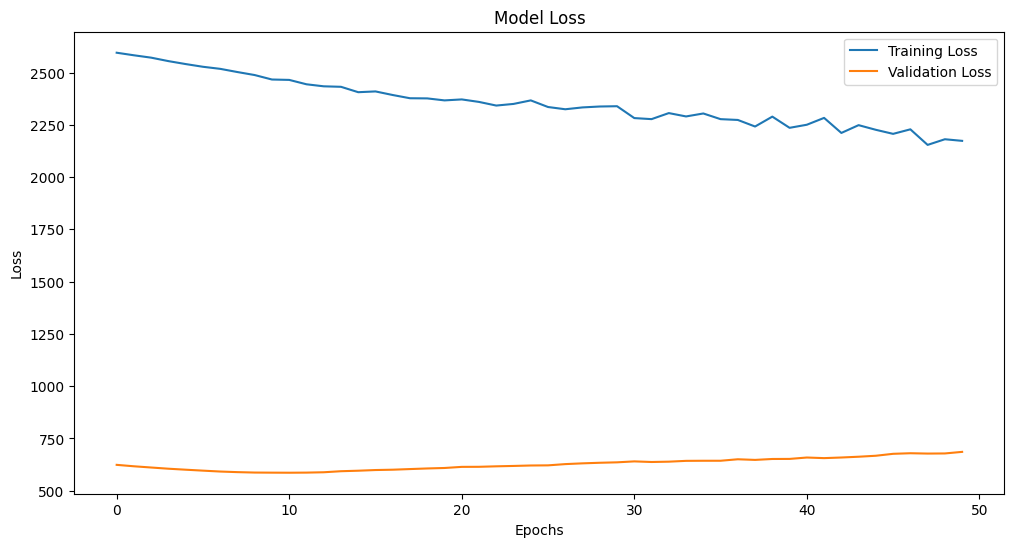

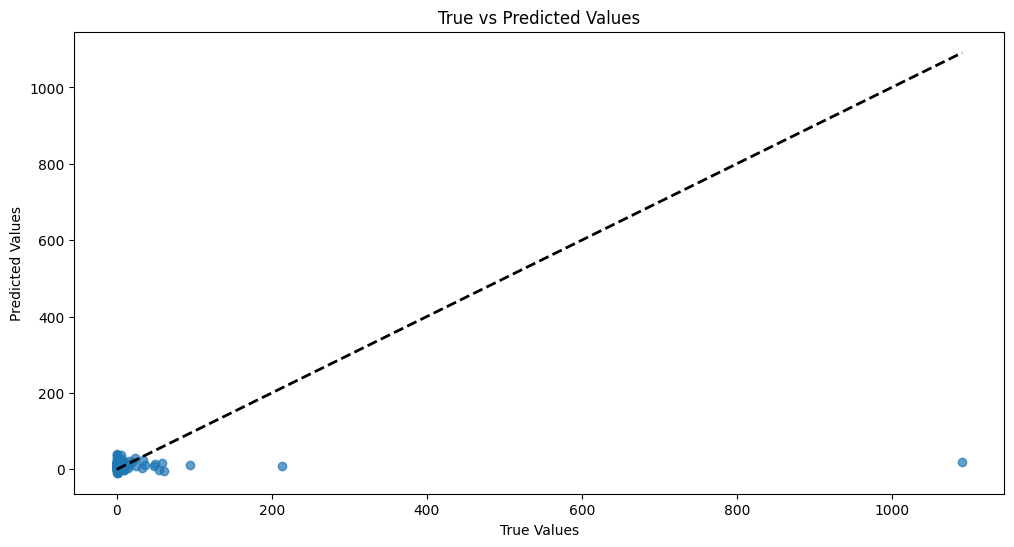

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from cryptography.fernet import Fernet
import matplotlib.pyplot as plt

# Generate encryption key
key = Fernet.generate_key()
cipher = Fernet(key)

# Encryption and decryption functions for numeric data
def encrypt_numeric_column(column):
    return column.apply(lambda x: cipher.encrypt(str(x).encode()))

def decrypt_numeric_column(column):
    return column.apply(lambda x: float(cipher.decrypt(x).decode()))

# Load the dataset
data = pd.read_csv("forestfires.csv")

# Convert categorical data to numeric using one-hot encoding
categorical_cols = ["month", "day"]
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Identify numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns

# Encrypt numeric columns
encrypted_data = data.copy()
for col in numeric_cols:
    encrypted_data[col] = encrypt_numeric_column(data[col])

# Decrypt numeric columns
decrypted_data = encrypted_data.copy()
for col in numeric_cols:
    decrypted_data[col] = decrypt_numeric_column(encrypted_data[col])

# Preprocess data: Feature scaling
scaler = StandardScaler()
X = decrypted_data.drop(columns=["area"])
y = decrypted_data["area"]
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define neural network model
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))  # Regression output

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title("True vs Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()


In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Use the existing preprocessed DataFrame
# Replace `preprocessed_data` with your actual preprocessed DataFrame variable
data = preprocessed_data

# Split features and target
X = data.drop(columns=['area'])
y = data['area']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Neural Network Model
def build_neural_network(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Train Neural Network
nn_model = build_neural_network(X_train.shape[1])
nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=0)
nn_predictions = nn_model.predict(X_test).flatten()
nn_mse = mean_squared_error(y_test, nn_predictions)
nn_r2 = r2_score(y_test, nn_predictions)

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

# Gradient Boosting Model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)

# Model Performance Summary
print("Neural Network:")
print(f"Mean Squared Error: {nn_mse:.2f}")
print(f"R2 Score: {nn_r2:.2f}\n")

print("Random Forest:")
print(f"Mean Squared Error: {rf_mse:.2f}")
print(f"R2 Score: {rf_r2:.2f}\n")

print("Gradient Boosting:")
print(f"Mean Squared Error: {gb_mse:.2f}")
print(f"R2 Score: {gb_r2:.2f}\n")

# Visualization
plt.figure(figsize=(12, 8))

plt.scatter(y_test, nn_predictions, label='Neural Network Predictions', alpha=0.7)
plt.scatter(y_test, rf_predictions, label='Random Forest Predictions', alpha=0.7)
plt.scatter(y_test, gb_predictions, label='Gradient Boosting Predictions', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Model Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Bar plot for MSE comparison
models = ['Neural Network', 'Random Forest', 'Gradient Boosting']
mse_values = [nn_mse, rf_mse, gb_mse]

plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color=['blue', 'green', 'orange'])
plt.title('Mean Squared Error Comparison')
plt.ylabel('Mean Squared Error')
plt.show()


NameError: name 'preprocessed_data' is not defined

4/4 [==============================] - 0s 2ms/step
Neural Network:
Mean Squared Error: 1.58
R2 Score: -0.73

Random Forest:
Mean Squared Error: 1.01
R2 Score: -0.11

Gradient Boosting:
Mean Squared Error: 1.18
R2 Score: -0.29



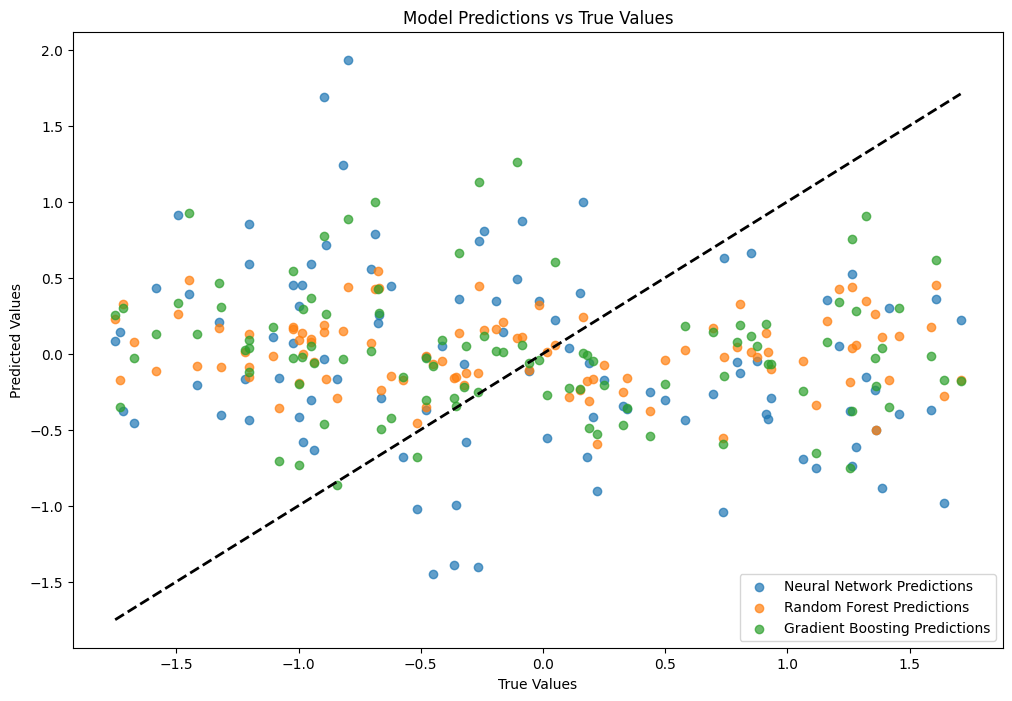

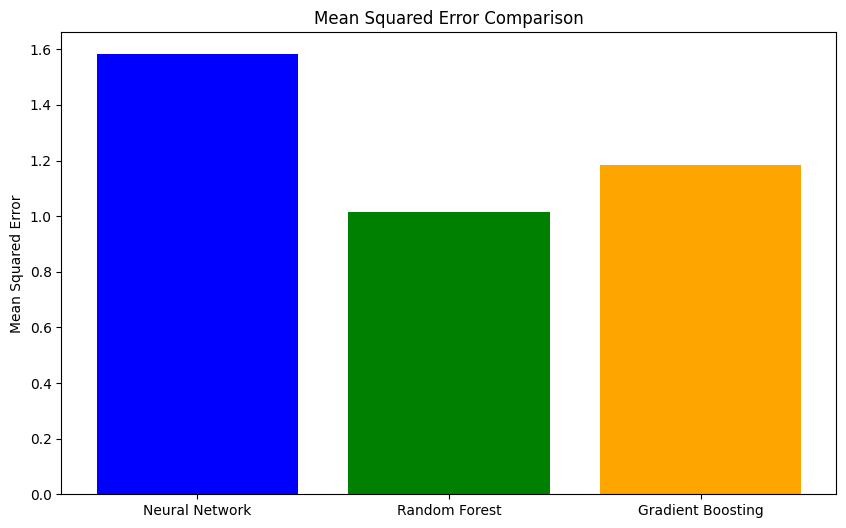

In [29]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Simulated preprocessing of data
# Replace this with your actual dataset
data = pd.DataFrame({
    'X': np.random.randint(1, 10, 500),
    'Y': np.random.randint(1, 10, 500),
    'month': np.random.randint(1, 12, 500),
    'day': np.random.randint(1, 7, 500),
    'FFMC': np.random.uniform(50, 90, 500),
    'DMC': np.random.uniform(1, 100, 500),
    'DC': np.random.uniform(10, 700, 500),
    'ISI': np.random.uniform(0.1, 20, 500),
    'temp': np.random.uniform(2, 40, 500),
    'RH': np.random.uniform(10, 100, 500),
    'wind': np.random.uniform(1, 10, 500),
    'rain': np.random.uniform(0, 1, 500),
    'area': np.random.uniform(0, 1000, 500)
})

# Data preprocessing
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data)
data = pd.DataFrame(scaled_features, columns=data.columns)

# Split features and target
X = data.drop(columns=['area'])
y = data['area']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1: Neural Network
def build_neural_network(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

nn_model = build_neural_network(X_train.shape[1])
nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=0)
nn_predictions = nn_model.predict(X_test).flatten()
nn_mse = mean_squared_error(y_test, nn_predictions)
nn_r2 = r2_score(y_test, nn_predictions)

# Model 2: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

# Model 3: Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)

# Display results
print("Neural Network:")
print(f"Mean Squared Error: {nn_mse:.2f}")
print(f"R2 Score: {nn_r2:.2f}\n")

print("Random Forest:")
print(f"Mean Squared Error: {rf_mse:.2f}")
print(f"R2 Score: {rf_r2:.2f}\n")

print("Gradient Boosting:")
print(f"Mean Squared Error: {gb_mse:.2f}")
print(f"R2 Score: {gb_r2:.2f}\n")

# Visualization
plt.figure(figsize=(12, 8))
plt.scatter(y_test, nn_predictions, label='Neural Network Predictions', alpha=0.7)
plt.scatter(y_test, rf_predictions, label='Random Forest Predictions', alpha=0.7)
plt.scatter(y_test, gb_predictions, label='Gradient Boosting Predictions', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Model Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Bar plot for MSE comparison
models = ['Neural Network', 'Random Forest', 'Gradient Boosting']
mse_values = [nn_mse, rf_mse, gb_mse]

plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color=['blue', 'green', 'orange'])
plt.title('Mean Squared Error Comparison')
plt.ylabel('Mean Squared Error')
plt.show()


               Model       MSE        R2
0     Neural Network  1.943711 -0.986590
1      Random Forest  1.053745 -0.071566
2  Gradient Boosting  1.177128 -0.196380


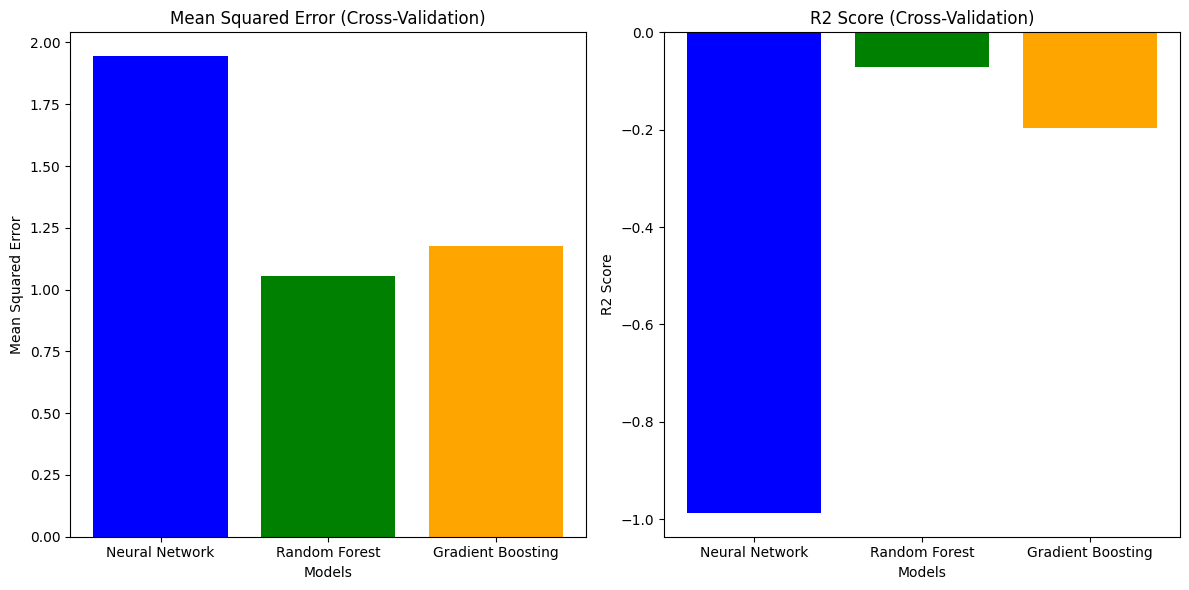

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assume `data` is already preprocessed
# Split features and target
X = data.drop(columns=["area"])
y = data["area"]

# Initialize models
models = {
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
}

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {"Model": [], "MSE": [], "R2": []}

# Perform cross-validation
for model_name, model in models.items():
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score)
    
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)    r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)
    
    results["Model"].append(model_name)
    results["MSE"].append(-np.mean(mse_scores))  # Take negative since mean_squared_error scorer returns negative
    results["R2"].append(np.mean(r2_scores))

# Convert results to DataFrame
cv_results = pd.DataFrame(results)

# Print results
print(cv_results)

# Visualize Results
plt.figure(figsize=(12, 6))
# MSE Comparison
plt.subplot(1, 2, 1)
plt.bar(cv_results["Model"], cv_results["MSE"], color=["blue", "green", "orange"])
plt.title("Mean Squared Error (Cross-Validation)")
plt.ylabel("Mean Squared Error")
plt.xlabel("Models")

# R2 Comparison
plt.subplot(1, 2, 2)
plt.bar(cv_results["Model"], cv_results["R2"], color=["blue", "green", "orange"])
plt.title("R2 Score (Cross-Validation)")
plt.ylabel("R2 Score")
plt.xlabel("Models")

plt.tight_layout()
plt.show()


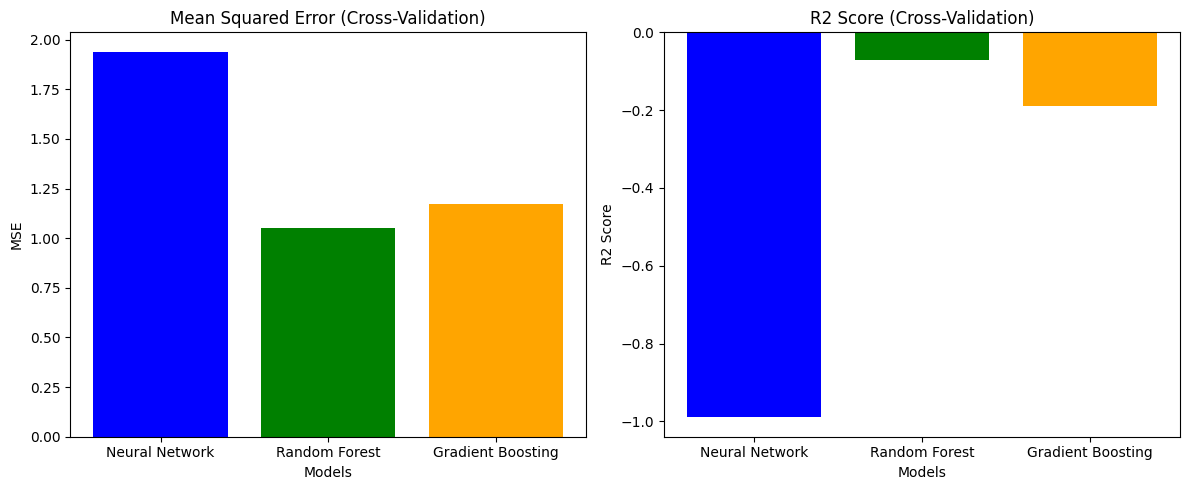

In [32]:
import matplotlib.pyplot as plt

# Results from your cross-validation
models = ["Neural Network", "Random Forest", "Gradient Boosting"]
mse_scores = [1.94, 1.05, 1.17]  # Replace with your actual MSE values
r2_scores = [-0.99, -0.07, -0.19]  # Replace with your actual R2 values

# Bar chart for MSE and R2 scores
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# MSE Comparison
axs[0].bar(models, mse_scores, color=['blue', 'green', 'orange'])
axs[0].set_title("Mean Squared Error (Cross-Validation)")
axs[0].set_ylabel("MSE")
axs[0].set_xlabel("Models")

# R2 Score Comparison
axs[1].bar(models, r2_scores, color=['blue', 'green', 'orange'])
axs[1].set_title("R2 Score (Cross-Validation)")
axs[1].set_ylabel("R2 Score")
axs[1].set_xlabel("Models")

plt.tight_layout()
plt.show()


4/4 [==============================] - 0s 4ms/step


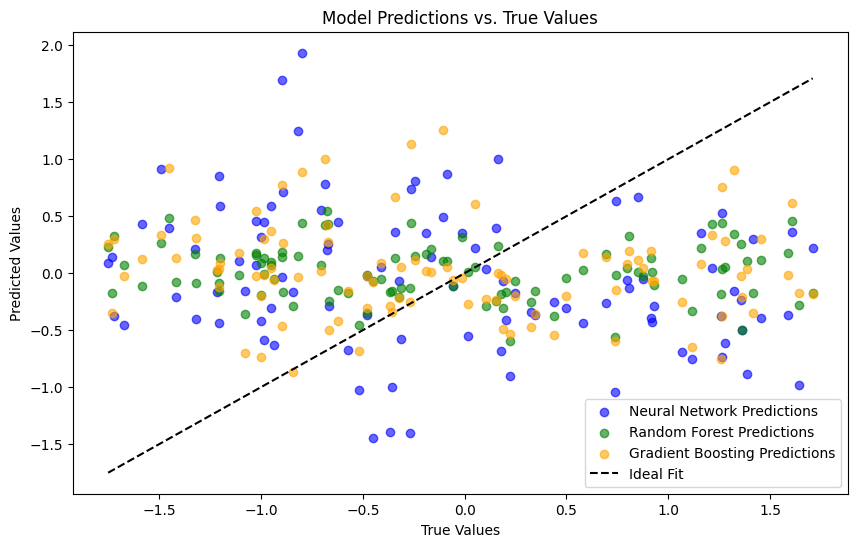

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your models and dataset are already split and predictions exist
# Replace these with actual generated predictions
true_values = y_test  # Actual test values
nn_predictions = nn_model.predict(X_test)  # Neural Network predictions
rf_predictions = rf_model.predict(X_test)  # Random Forest predictions
gb_predictions = gb_model.predict(X_test)  # Gradient Boosting predictions

# Scatter plot for predictions vs true values
plt.figure(figsize=(10, 6))
plt.scatter(true_values, nn_predictions, label="Neural Network Predictions", alpha=0.6, color='blue')
plt.scatter(true_values, rf_predictions, label="Random Forest Predictions", alpha=0.6, color='green')
plt.scatter(true_values, gb_predictions, label="Gradient Boosting Predictions", alpha=0.6, color='orange')
plt.plot(np.linspace(min(true_values), max(true_values)), np.linspace(min(true_values), max(true_values)), '--k', label="Ideal Fit")
plt.title("Model Predictions vs. True Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()
